# SARIMAX
## Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv(r'F:\DS\Time_Series_Analysis\[ FreeCourseWeb.com ] Udemy - Python for Time Series Data Analysis\01. Introduction\UDEMY_TSA_FINAL\Data\RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'

In [3]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


In [4]:
df.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [5]:
df1 = df.dropna()
df1.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


In [6]:
# Change the dtype of selected columns
cols = ['rest1','rest2','rest3','rest4','total']
for col in cols:
    df1[col] = df1[col].astype(int)
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


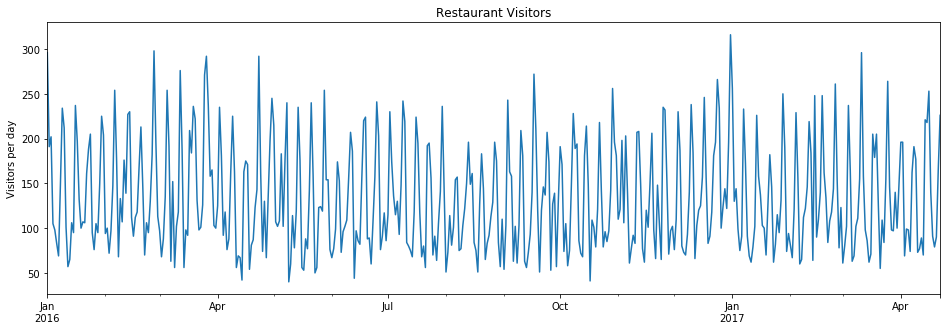

In [7]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Look At the Holidays

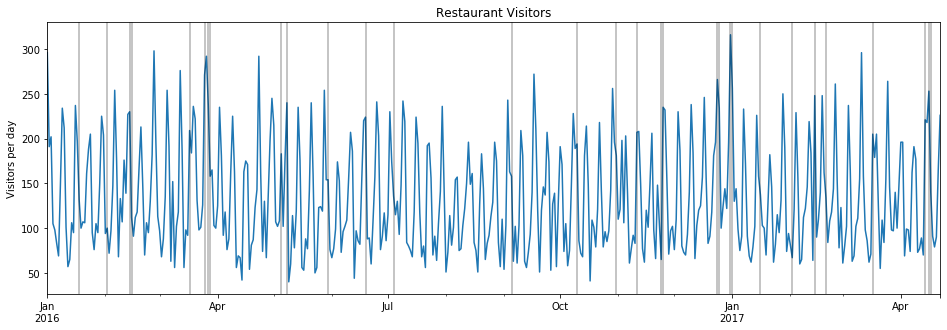

In [8]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df1.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.3);  # add a semi-transparent grey line

### Run_ETS_Decomposition

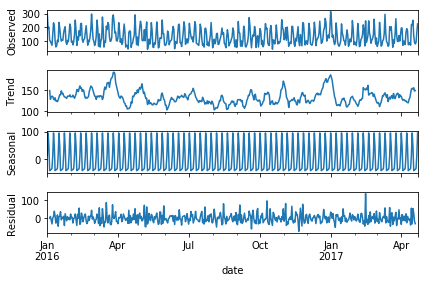

In [9]:
result = seasonal_decompose(df1['total'])
result.plot();

### Test_for_stationarity

In [10]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [11]:
adf_test(df1['total'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Run_pmdarina_for_the_Order_selection 

In [12]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df1['total'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                           
===============================================================================
Dep. Variable:                       y   No. Observations:                  478
Model:             SARIMAX(1, 0, 1, 7)   Log Likelihood               -2384.969
Date:                 Sun, 02 Feb 2020   AIC                           4777.937
Time:                         12:02:53   BIC                           4794.616
Sample:                              0   HQIC                          4784.495
                                 - 478                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.5497      1.628      2.795      0.005       1.359       7.740
ar.S.L7        0.9627      0.013     74.315      0.000       0.937       0.988
ma.S.L7       -0.7680      0.048    -15.838      0.000      -0.863      -0.673
sigma2      1229.7926     73.728     16.680      0.000    1085.288    1374.297
===================================================================================
Ljung-Box (Q):                       69.27   Jarque-Bera (JB):                68.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.77
Prob(H) (two-sided):                  0.29   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Split_the_Data

In [13]:
len(df1)

478

In [14]:
# Set four weeks for testing
train = df1.iloc[:436]
test = df1.iloc[436:]

### Fit_SARIMA_Model_(1,0,0)(2,0,0,7)

#### NOTE: To avoid a ValueError: non-invertible starting MA parameters found we're going to set enforce_invertibility to False.

In [15]:
model = SARIMAX(train['total'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2224.701
Date:                           Sun, 02 Feb 2020   AIC                           4457.403
Time:                                   12:04:50   BIC                           4473.713
Sample:                               01-01-2016   HQIC                          4463.840
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2212      0.047      4.711      0.000       0.129       0.313
ar.S.L7        0.5063      0.036     14.187      0.000       0.436       0.576
ar.S.L14       0.4574      0.037     12.379      0.000       0.385       0.530
sigma2      1520.2899     82.277     18.478      0.000    1359.029    1681.550
===================================================================================
Ljung-Box (Q):                       83.96   Jarque-Bera (JB):                29.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.34
Prob(H) (two-sided):                  0.37   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,0,0)(2,0,0,7) Predictions')

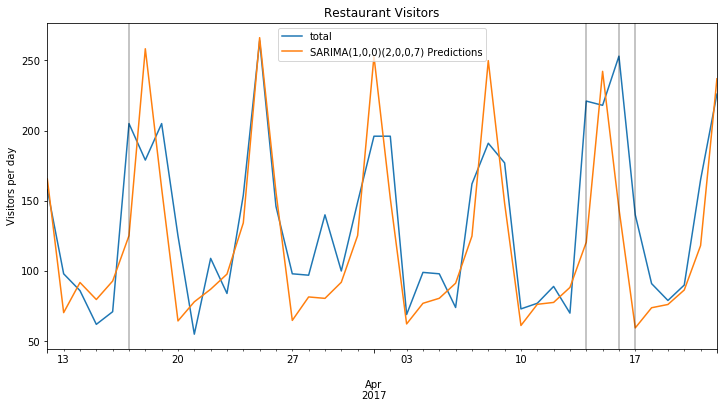

In [17]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

## Evaluate_the_Model

In [18]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['total'], predictions)
error2 = rmse(test['total'], predictions)

print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 1702.647955
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 41.26315493


### Now_Add_exog_variable

In [19]:
model = SARIMAX(train['total'],exog=train['holiday'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2158.482
Date:                           Sun, 02 Feb 2020   AIC                           4326.963
Time:                                   12:06:13   BIC                           4347.352
Sample:                               01-01-2016   HQIC                          4335.010
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       66.8887      4.241     15.774      0.000      58.577      75.200
ar.L1          0.2145      0.049      4.375      0.000       0.118       0.311
ar.S.L7        0.5147      0.042     12.312      0.000       0.433       0.597
ar.S.L14       0.4575      0.042     10.997      0.000       0.376       0.539
sigma2      1117.3953     73.301     15.244      0.000     973.727    1261.063
===================================================================================
Ljung-Box (Q):                      100.96   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.00   Prob(JB):                         0.54
Heteroskedasticity (H):               0.91   Skew:                             0.11
Prob(H) (two-sided):                  0.58   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Predictions')

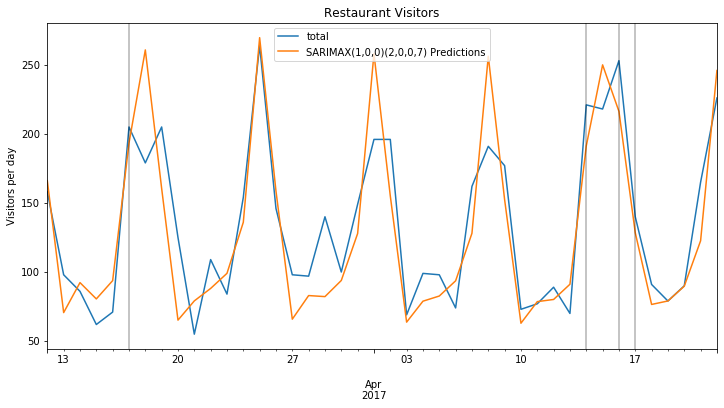

In [21]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

## Evaluate_the_Model

In [22]:
# Print values from SARIMA above
print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')
print()

error1x = mse(test['total'], predictions)
error2x = rmse(test['total'], predictions)

# Print new SARIMAX values
print(f'SARIMAX(1,0,0)(2,0,0,7) MSE Error: {error1x:11.10}')
print(f'SARIMAX(1,0,0)(2,0,0,7) RMSE Error: {error2x:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 1702.647955
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 41.26315493

SARIMAX(1,0,0)(2,0,0,7) MSE Error: 950.6692299
SARIMAX(1,0,0)(2,0,0,7) RMSE Error: 30.83292445


## Run_The_Model_on_full_Datasets_and_Forecast_The_Future

In [23]:
model = SARIMAX(df1['total'],exog=df1['holiday'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:][['holiday']]
fcast = results.predict(len(df1),len(df1)+38,exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Forecast')

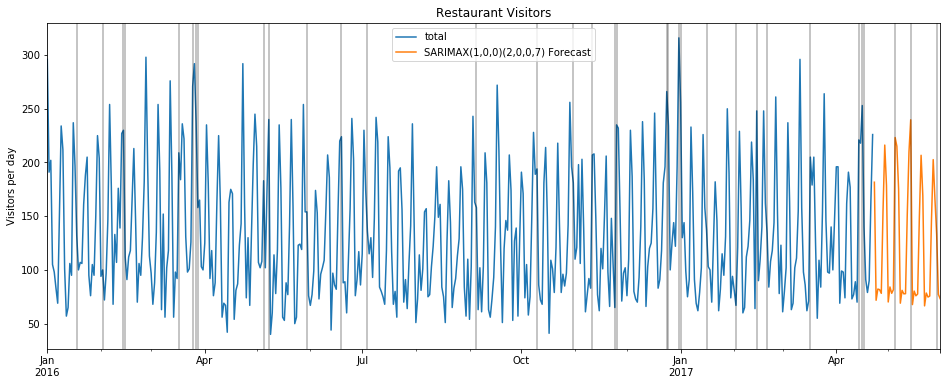

In [24]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);